# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Загружаем разметку

In [6]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = './Рыбки/train'

def load_boxes():
    boxes = dict()
    for path in glob('boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [7]:
boxes = load_boxes()  # разметка детекций

In [8]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


In [9]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['lag'][17])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x720 with 0 Axes>

### Распределение размеров разметки

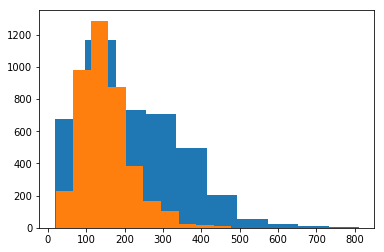

In [10]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [11]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

# Сетка якорей (anchor grid)

In [12]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [13]:
LABELS_DICT = {}
REVERSE_DICT = {}

for i,x in enumerate(boxes.keys()):
    LABELS_DICT[x] = i
    REVERSE_DICT[i] = x

CLASSES_NUM = len(LABELS_DICT)

In [14]:
LABELS_DICT ,CLASSES_NUM, boxes.keys(), REVERSE_DICT

({'alb': 0, 'bet': 1, 'dol': 2, 'lag': 3, 'shark': 4, 'yft': 5},
 6,
 dict_keys(['alb', 'bet', 'dol', 'lag', 'shark', 'yft']),
 {0: 'alb', 1: 'bet', 2: 'dol', 3: 'lag', 4: 'shark', 5: 'yft'})

In [15]:
for x in boxes.keys():
    for b in boxes[x]:
        b['label'] = x

In [16]:
from keras.utils.np_utils import to_categorical   

categorical_labels = to_categorical(list(REVERSE_DICT.keys()), num_classes=CLASSES_NUM)
categorical_labels

Using TensorFlow backend.


array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [17]:
REVERSE_DICT

{0: 'alb', 1: 'bet', 2: 'dol', 3: 'lag', 4: 'shark', 5: 'yft'}

In [18]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, label_name, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5+CLASSES_NUM), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]
#TODO add classes one hot
        class_num = LABELS_DICT[label_name]
    
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
    
            encoded[row, col] = [1., dx, dy, dw, dh]+list(categorical_labels[class_num])
        
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
#             print(prediction[row, col])
#             print(prediction[row, col])
            out_list = prediction[row, col].tolist()
            logit, dx, dy, dw, dh, one_hot_class =out_list[0], out_list[1], out_list[2], out_list[3],out_list[4], out_list[5:]
            label_index = np.argmax(one_hot_class, axis=0) 
            conf = _sigmoid(logit)
#             print(logit, dx, dy, dw, dh, one_hot_class )
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': REVERSE_DICT[label_index]})
    return rectangles

### Валидация енкодинга/декодинга

TypeError: 'NoneType' object is not subscriptable

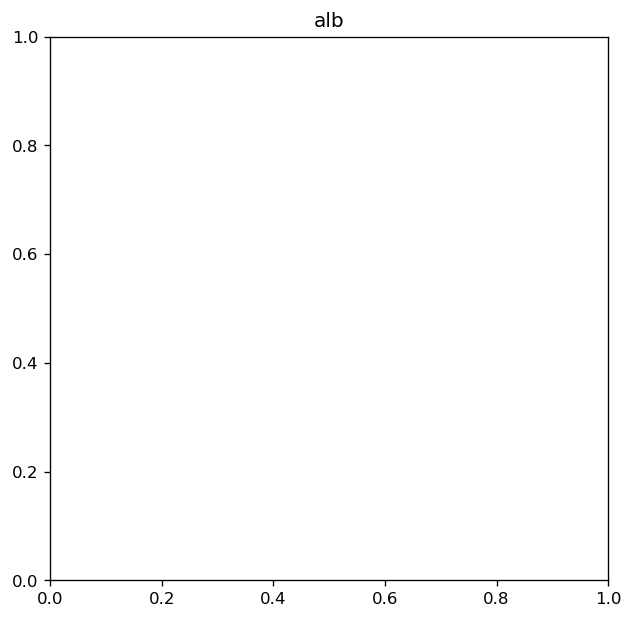

In [19]:
example = boxes['alb'][178]
# print(boxes['alb'][178]['label'])
encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH), boxes['alb'][178]['label'])
# print(encoded[0])

decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])
# print(decoded)
plt.figure(figsize=(6, 6), dpi=120)
plt.title('{}'.format(decoded[0]['label']));
plt.imshow(draw_boxes(example, decoded[:10]))

## Функция потерь

## Загрузка данных

In [20]:
K = tf.keras.backend


# def weighted_categorical_crossentropy(y_true, y_pred, weights):
#     nb_cl = len(weights)
#     final_mask = K.zeros_like(y_pred[:, 0])
#     y_pred_max = K.max(y_pred, axis=1)
#     y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
#     y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
#     for c_p, c_t in product(range(nb_cl), range(nb_cl)):
#         final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
#     cross_ent = K.categorical_crossentropy(y_pred, y_true, from_logits=False)
#     return cross_ent * final_mask
def classification_loss(y_true, y_pred):
    class_loss =  K.categorical_crossentropy(y_true[..., 5:], 
                                      y_pred[..., 5:],
                                      from_logits=False)
    return class_loss


def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5+CLASSES_NUM))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5+CLASSES_NUM))
    class_true = K.reshape(y_true[...,5:],(-1,))
    class_pred =  K.reshape(y_pred[...,5:],(-1,))
#     print(class_true, class_pred)
    y_true = y_true[...,:5]
    y_pred = y_pred[...,:5]

    #classification loss
    class_loss = K.categorical_crossentropy(class_true, class_pred, from_logits=False)
    
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + class_loss

In [21]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape, boxes[j]['label']))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [22]:
output = keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D(5+CLASSES_NUM,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2')(output)

model = keras.models.Model(inputs=features.inputs, outputs=output)
# model.summary()

## Обучение

In [23]:
adam = keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss, 'class_loss': classification_loss})

In [24]:
batch_size = 5
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=10000,
                    callbacks=[checkpoint])

Epoch 1/10000


TypeError: 'NoneType' object is not subscriptable

## Результат работы детектора

In [ ]:
example = boxes['lag'][17]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]

decoded = decode_prediction(pred, conf_thr=0.)
decoded = sorted(decoded, key=lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:3], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

## Агрегация результатов

In [25]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0